In [1]:
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage.filters import gaussian_filter
from tifffile.tifffile import imsave

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.paths import caiman_datadir

import bokeh.plotting as bpl
bpl.output_notebook()
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)

1


Loading BokehJS ...

Define a function to create some toy data

In [2]:
def gen_data(p=1, noise=.5, T=256, framerate=30, firerate=2., motion=True, plot=False):
    if p == 2:
        gamma = np.array([1.5, -.55])
    elif p == 1:
        gamma = np.array([.9])
    else:
        raise
    dims = (70, 50, 10)  # size of image
    sig = (4, 4, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(0)#7)
    centers = np.asarray([[np.random.randint(s, x - s)
                           for x, s in zip(dims, sig)] for i in range(N)])
    if motion:
        centers += np.array(sig) * 2
        Y = np.zeros((T,) + tuple(np.array(dims) + np.array(sig) * 4), dtype=np.float32)      
    else:
        Y = np.zeros((T,) + dims, dtype=np.float32)
    trueSpikes = np.random.rand(N, T) < firerate / float(framerate)
    trueSpikes[:, 0] = 0
    truth = trueSpikes.astype(np.float32)
    for i in range(2, T):
        if p == 2:
            truth[:, i] += gamma[0] * truth[:, i - 1] + gamma[1] * truth[:, i - 2]
        else:
            truth[:, i] += gamma[0] * truth[:, i - 1]
    for i in range(N):
        Y[:, centers[i, 0], centers[i, 1], centers[i, 2]] = truth[i]
    tmp = np.zeros(dims)
    tmp[tuple(np.array(dims)//2)] = 1.
    z = np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Y = bkgrd + noise * np.random.randn(*Y.shape) + 10 * gaussian_filter(Y, (0,) + sig) / z
    if motion:
        shifts = np.transpose([np.convolve(np.random.randn(T-10), np.ones(11)/11*s) for s in sig])
        Y = np.array([cm.motion_correction.apply_shifts_dft(img, (sh[0], sh[1], sh[2]), 0,
                                                                     is_freq=False, border_nan='copy')
                               for img, sh in zip(Y, shifts)])
        Y = Y[:, 2*sig[0]:-2*sig[0], 2*sig[1]:-2*sig[1], 2*sig[2]:-2*sig[2]]
    else:
        shifts = None
    T, d1, d2, d3 = Y.shape

    if plot:
        Cn = cm.local_correlations(Y, swap_dim=False)
        plt.figure(figsize=(15, 3))
        plt.plot(truth.T)
        plt.figure(figsize=(15, 3))
        for c in centers:
            plt.plot(Y[c[0], c[1], c[2]])

        d1, d2, d3 = dims
        x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
        scale = 6/x
        fig = plt.figure(figsize=(scale*x, scale*y))
        axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
        plt.imshow(Cn.max(2).T, cmap='gray')
        plt.scatter(*centers.T[:2], c='r')
        plt.title('Max.proj. z')
        plt.xlabel('x')
        plt.ylabel('y')
        axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
        plt.imshow(Cn.max(0), cmap='gray')
        plt.scatter(*centers.T[:0:-1], c='r')
        plt.title('Max.proj. x')
        plt.xlabel('z')
        plt.ylabel('y')
        axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
        plt.imshow(Cn.max(1).T, cmap='gray')
        plt.scatter(*centers.T[np.array([0,2])], c='r')
        plt.title('Max.proj. y')
        plt.xlabel('x')
        plt.ylabel('z');
        plt.show()

    return Y, truth, trueSpikes, centers, dims, -shifts

### Select file(s) to be processed
- create a file with a toy 3d dataset.

      115887 [font_manager.py:    _findfont_cached():1329] [31562] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
      115888 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
      115888 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
      115889 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
      115890 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
      115890 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
      115891 [font_manager.py:    _findfont_cache

      115911 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Oblique.ttf) oblique normal 500 normal>) = 11.145
      115912 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Times New Roman' (times.ttf) normal normal 400 normal>) = 10.05
      115912 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Tlwg Mono' (TlwgMono.ttf) normal normal 500 normal>) = 10.145
      115913 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Alegreya Sans' (Alegreya_Sans_Ultra_Bold_Italic.ttf) italic normal 800 normal>) = 11.43
      115918 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Lato' (Lato-Semibold.ttf) normal normal 600 normal>) = 10.24
      115918 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'UnPilgia' (UnPilgia.ttf) normal normal 400 normal>) = 10.05
      115919 [font_manager.py:    _findfont_cached():1

      115945 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 500 normal>) = 10.145
      115945 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Times New Roman' (Times_New_Roman.ttf) normal normal 400 normal>) = 10.05
      115946 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Italic.ttf) italic normal 400 normal>) = 11.05
      115946 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Universalis ADF Std' (UniversalisADFStd-Oblique.otf) oblique normal 400 normal>) = 11.05
      115946 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
      115947 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'msbm10' (msbm10.ttf) normal normal 400 normal>) = 10.05
      115948 [fo

      115965 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Georgia' (Georgia_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
      115965 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
      115966 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
      115966 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'GFS Didot' (GFSDidotBold.otf) normal normal 700 normal>) = 10.335
      115967 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Bitstream Vera Sans' (VeraIt.ttf) oblique normal 400 normal>) = 1.9590909090909092
      115967 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
      115967 [font_manager.py:    _findfont_cache

      115997 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Umpush' (Umpush-LightOblique.ttf) oblique normal 300 normal>) = 11.145
      115997 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Courier Prime' (Courier_Prime_Italic.ttf) italic normal 400 normal>) = 11.05
      115997 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Universalis ADF Std' (UniversalisADFStd-BoldOblique.otf) oblique normal 700 normal>) = 11.335
      115998 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Sans' (IBM_Plex_Sans_Bold.ttf) normal normal 700 normal>) = 10.335
      115998 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
      115999 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'GFS Gazis' (GFSGazis.otf) normal normal 400 normal>) = 10.05
      115999 [font_

      116022 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'KacstOffice' (KacstOffice.ttf) normal normal 500 normal>) = 10.145
      116023 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal 800 normal>) = 10.43
      116023 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Norasi' (Norasi-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
      116024 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'GFS Didot' (GFSDidotBoldItalic.otf) italic normal 700 normal>) = 11.335
      116024 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Purisa' (Purisa-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
      116025 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Roboto' (Roboto_Regular.ttf) normal normal 400 normal>) = 10.05
      116025 [font_manager.py:    _findfont_cached():1341] 

      116052 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 500 normal>) = 11.145
      116053 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Laksaman' (Laksaman.ttf) normal normal 400 normal>) = 10.05
      116053 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
      116053 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'KacstOne' (KacstOne-Bold.ttf) normal normal 700 normal>) = 10.335
      116054 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS_Italic.ttf) italic normal 400 normal>) = 11.05
      116055 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Loma' (Loma-Oblique.ttf) oblique normal 400 normal>) = 11.05
      116055 [font_manager.py:    _findfont_cached():1341] [31562

      116075 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
      116078 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Universalis ADF Cd Std' (UniversalisADFCdStd-Bold.otf) normal normal 700 normal>) = 10.335
      116078 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
      116079 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
      116079 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Sans' (IBM_Plex_Sans_Semi_Bold_Italic.ttf) italic normal 600 normal>) = 11.24
      116080 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Ultra_Light.ttf) normal normal 200 norm

      116103 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'UnDinaru' (UnDinaruBold.ttf) normal normal 700 normal>) = 10.335
      116104 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'GFS BodoniClassic' (GFSBodoniClassic.otf) normal normal 400 normal>) = 10.05
      116104 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
      116105 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Linux Libertine O' (LinLibertine_RBI.otf) italic normal 700 normal>) = 11.335
      116105 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
      116106 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 500 normal>) = 10.145
      116106 [font_manager.py:    _findfont_cached():1

      116136 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
      116136 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Garuda' (Garuda.ttf) normal normal 400 normal>) = 10.05
      116137 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Linux Biolinum O' (LinBiolinum_R.otf) normal normal 400 normal>) = 10.05
      116138 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
      116138 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'NanumMyeongjo' (NanumMyeongjoBold.ttf) normal normal 600 normal>) = 10.24
      116139 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Alegreya Sans' (Alegreya_Sans_Ultra_Bold.ttf) normal normal 800 normal>) = 10.43
      116139 [font_manager.py

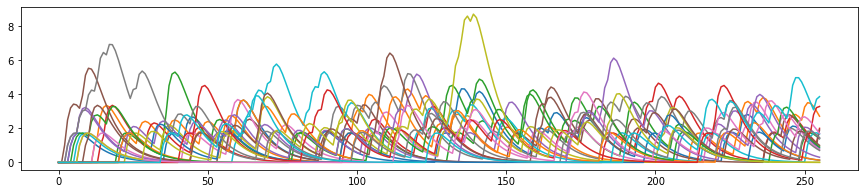

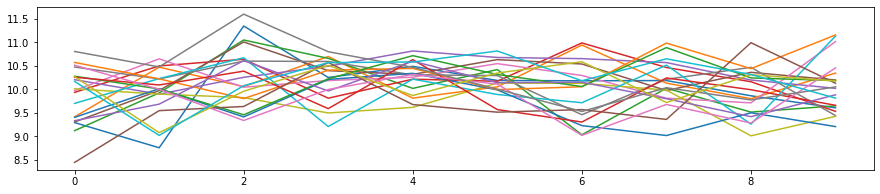

      116425 [font_manager.py:    _findfont_cached():1329] [31562] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
      116426 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
      116427 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
      116427 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
      116427 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
      116428 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
      116428 [font_manager.py:    _findfont_cache

      116453 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Oblique.ttf) oblique normal 500 normal>) = 11.145
      116453 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Times New Roman' (times.ttf) normal normal 400 normal>) = 10.05
      116454 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Tlwg Mono' (TlwgMono.ttf) normal normal 500 normal>) = 10.145
      116454 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Alegreya Sans' (Alegreya_Sans_Ultra_Bold_Italic.ttf) italic normal 800 normal>) = 11.43
      116455 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Lato' (Lato-Semibold.ttf) normal normal 600 normal>) = 10.24
      116455 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'UnPilgia' (UnPilgia.ttf) normal normal 400 normal>) = 10.05
      116455 [font_manager.py:    _findfont_cached():1

      116493 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 500 normal>) = 10.145
      116493 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Times New Roman' (Times_New_Roman.ttf) normal normal 400 normal>) = 10.05
      116494 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Italic.ttf) italic normal 400 normal>) = 11.05
      116495 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Universalis ADF Std' (UniversalisADFStd-Oblique.otf) oblique normal 400 normal>) = 11.05
      116495 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
      116496 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'msbm10' (msbm10.ttf) normal normal 400 normal>) = 10.05
      116496 [fo

      116533 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Georgia' (Georgia_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
      116534 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
      116534 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
      116535 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'GFS Didot' (GFSDidotBold.otf) normal normal 700 normal>) = 10.335
      116536 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Bitstream Vera Sans' (VeraIt.ttf) oblique normal 400 normal>) = 1.9590909090909092
      116536 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
      116537 [font_manager.py:    _findfont_cache

      116563 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Umpush' (Umpush-LightOblique.ttf) oblique normal 300 normal>) = 11.145
      116563 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Courier Prime' (Courier_Prime_Italic.ttf) italic normal 400 normal>) = 11.05
      116564 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Universalis ADF Std' (UniversalisADFStd-BoldOblique.otf) oblique normal 700 normal>) = 11.335
      116564 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Sans' (IBM_Plex_Sans_Bold.ttf) normal normal 700 normal>) = 10.335
      116565 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
      116565 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'GFS Gazis' (GFSGazis.otf) normal normal 400 normal>) = 10.05
      116566 [font_

      116589 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'KacstOffice' (KacstOffice.ttf) normal normal 500 normal>) = 10.145
      116589 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal 800 normal>) = 10.43
      116589 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Norasi' (Norasi-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
      116590 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'GFS Didot' (GFSDidotBoldItalic.otf) italic normal 700 normal>) = 11.335
      116590 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Purisa' (Purisa-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
      116590 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Roboto' (Roboto_Regular.ttf) normal normal 400 normal>) = 10.05
      116591 [font_manager.py:    _findfont_cached():1341] 

      116622 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 500 normal>) = 11.145
      116622 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Laksaman' (Laksaman.ttf) normal normal 400 normal>) = 10.05
      116623 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
      116623 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'KacstOne' (KacstOne-Bold.ttf) normal normal 700 normal>) = 10.335
      116623 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS_Italic.ttf) italic normal 400 normal>) = 11.05
      116624 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Loma' (Loma-Oblique.ttf) oblique normal 400 normal>) = 11.05
      116624 [font_manager.py:    _findfont_cached():1341] [31562

      116651 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
      116651 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Universalis ADF Cd Std' (UniversalisADFCdStd-Bold.otf) normal normal 700 normal>) = 10.335
      116652 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
      116652 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
      116653 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Sans' (IBM_Plex_Sans_Semi_Bold_Italic.ttf) italic normal 600 normal>) = 11.24
      116653 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'IBM Plex Mono' (IBM_Plex_Mono_Ultra_Light.ttf) normal normal 200 norm

      116674 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'UnDinaru' (UnDinaruBold.ttf) normal normal 700 normal>) = 10.335
      116674 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'GFS BodoniClassic' (GFSBodoniClassic.otf) normal normal 400 normal>) = 10.05
      116675 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
      116675 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Linux Libertine O' (LinLibertine_RBI.otf) italic normal 700 normal>) = 11.335
      116676 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
      116677 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 500 normal>) = 10.145
      116678 [font_manager.py:    _findfont_cached():1

      116707 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
      116707 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Garuda' (Garuda.ttf) normal normal 400 normal>) = 10.05
      116708 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Linux Biolinum O' (LinBiolinum_R.otf) normal normal 400 normal>) = 10.05
      116708 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
      116709 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'NanumMyeongjo' (NanumMyeongjoBold.ttf) normal normal 600 normal>) = 10.24
      116710 [font_manager.py:    _findfont_cached():1341] [31562] findfont: score(<Font 'Alegreya Sans' (Alegreya_Sans_Ultra_Bold.ttf) normal normal 800 normal>) = 10.43
      116710 [font_manager.py

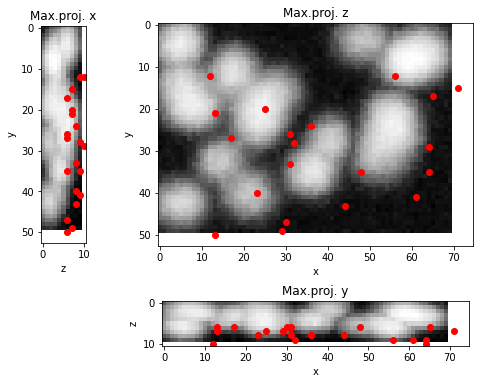

/home/remy/caiman_data/example_movies/demoMovie3D.tif
(256, 70, 50, 10)


In [4]:
fname = os.path.join(caiman_datadir(), 'example_movies', 'demoMovie3D.tif')
Y, truth, trueSpikes, centers, dims, shifts = gen_data(p=2, plot=True)
imsave(fname, Y)


### Display the raw movie (optional)

Show a max-projection of the correlation image

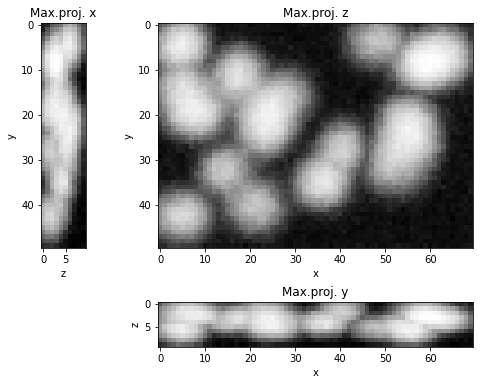

In [6]:
Y = cm.load(fname)
Cn = cm.local_correlations(Y, swap_dim=False)
d1, d2, d3 = dims
x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
scale = 6/x
fig = plt.figure(figsize=(scale*x, scale*y))
axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
plt.imshow(Cn.max(2).T, cmap='gray')
plt.title('Max.proj. z')
plt.xlabel('x')
plt.ylabel('y')
axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
plt.imshow(Cn.max(0), cmap='gray')
plt.title('Max.proj. x')
plt.xlabel('z')
plt.ylabel('y')
axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
plt.imshow(Cn.max(1).T, cmap='gray')
plt.title('Max.proj. y')
plt.xlabel('x')
plt.ylabel('z');
plt.show()

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel.

In [7]:
Y[...,5].play(magnification=2)

### Setup a cluster

In [8]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

### Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [9]:
# motion correction parameters
opts_dict = {'fnames': fname,
            'strides': (24, 24, 6),    # start a new patch for pw-rigid motion correction every x pixels
            'overlaps': (12, 12, 2),   # overlap between pathes (size of patch strides+overlaps)
            'max_shifts': (4, 4, 2),   # maximum allowed rigid shifts (in pixels)
            'max_deviation_rigid': 5,  # maximum shifts deviation allowed for patch with respect to rigid shifts
            'pw_rigid': False,         # flag for performing non-rigid motion correction
            'is3D': True}

opts = cnmf.params.CNMFParams(params_dict=opts_dict)

     4668979 [params.py:                 set():971] [31562] Changing key fnames in group data from None to /home/remy/caiman_data/example_movies/demoMovie3D.tif
     4668979 [params.py:                 set():971] [31562] Changing key strides in group motion from (96, 96) to (24, 24, 6)
     4668980 [params.py:                 set():971] [31562] Changing key overlaps in group motion from (32, 32) to (12, 12, 2)
     4668981 [params.py:                 set():971] [31562] Changing key max_shifts in group motion from (6, 6) to (4, 4, 2)
     4668981 [params.py:                 set():971] [31562] Changing key max_deviation_rigid in group motion from 3 to 5
     4668981 [params.py:                 set():971] [31562] Changing key is3D in group motion from False to True
     4669078 [params.py:   check_consistency():940] [31562] is3D=True, hence setting key indices automatically to (slice(None, None, None), slice(None, None, None), slice(None, None, None))


In [10]:
print(fname)

/home/remy/caiman_data/example_movies/demoMovie3D.tif


In [ ]:
# first we create a motion correction object with the parameters specified
mc = cm.motion_correction.MotionCorrect(fname, dview=dview, **opts.get_group('motion'))
# note that the file is not loaded in memory

In [ ]:
%%capture
#%% Run motion correction using NoRMCorre
mc.motion_correct(save_movie=True)
m_rig = cm.load(mc.fname_tot_rig, is3D=True)

In [ ]:
plt.figure(figsize=(12,3))
for i, s in enumerate((mc.shifts_rig, shifts)):
    plt.subplot(1,2,i+1)
    for k in (0,1,2):
        plt.plot(np.array(s)[:,k], label=('x','y','z')[k])
    plt.legend()
    plt.title(('inferred shifts', 'true shifts')[i])
    plt.xlabel('frames')
    plt.ylabel('pixels')

### Memory mapping 

The cell below memory maps the file in order `'C'` and then loads the new memory mapped file. The saved files from motion correction are memory mapped files stored in `'F'` order. Their paths are stored in `mc.mmap_file`.

In [ ]:
#%% MEMORY MAPPING
# memory map the file in order 'C'
fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                           border_to_0=0, dview=dview) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

Now restart the cluster to clean up memory

In [ ]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

## If data is small enough use a single patch approach

In [ ]:
# set parameters
K = 20  # number of neurons expected per patch
gSig = [4, 4, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system

### Run CNMF

In [ ]:
# INIT
cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview)

In [ ]:
%%capture
# FIT
cnm = cnm.fit(images)

### View the results
View components per plane

In [ ]:
cnm.estimates.nb_view_components_3d(image_type='mean', dims=dims, axis=2);

### With padding

In [ ]:
# INIT
cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview)

In [ ]:
%%capture
# FIT
cnm = cnm.fit(np.pad(images, ((0,0),(1,1),(1,1),(1,1))))

In [ ]:
cnm.estimates.nb_view_components_3d(image_type='mean', dims=np.array(dims)+2, axis=2);

## For larger data use a patch approach

In [ ]:
# set parameters
rf = 15  # half-size of the patches in pixels. rf=25, patches are 50x50
stride = 10  # amount of overlap between the patches in pixels
K = 10  # number of neurons expected per patch
gSig = [4, 4, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system

### Run CNMF

In [ ]:
%%capture
#%% RUN ALGORITHM ON PATCHES

cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview,
                rf=rf, stride=stride, only_init_patch=True)
cnm = cnm.fit(images)

print(('Number of components:' + str(cnm.estimates.A.shape[-1])))

### Component Evaluation

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in two ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient

fr = 10 # approx final rate  (after eventual downsampling )
decay_time = 1.  # length of typical transient in seconds 
use_cnn = False  # CNN classifier is designed for 2d (real) data
min_SNR = 3      # accept components with that peak-SNR or higher
rval_thr = 0.6   # accept components with space correlation threshold or higher
cnm.params.change_params(params_dict={'fr': fr,
                                      'decay_time': decay_time,
                                      'min_SNR': min_SNR,
                                      'rval_thr': rval_thr,
                                      'use_cnn': use_cnn})

cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

In [ ]:
print(('Keeping ' + str(len(cnm.estimates.idx_components)) +
       ' and discarding  ' + str(len(cnm.estimates.idx_components_bad))))

### Re-run seeded CNMF
Now we re-run CNMF on the whole FOV seeded with the accepted components.

In [ ]:
%%capture
cnm.params.set('temporal', {'p': p})
cnm2 = cnm.refit(images)

### View the results
For a change we view the components as max-projections (frontal in the XY direction, sagittal in YZ direction and transverse in XZ),
and we additionaly show the denoised trace

In [ ]:
cnm2.estimates.nb_view_components_3d(image_type='corr', dims=dims, Yr=Yr, denoised_color='red', max_projection=True);

In [ ]:
# STOP CLUSTER
cm.stop_server(dview=dview)